In [1]:
# Look for *.tif files in all subfolders.
from os import walk
from os.path import join
import fnmatch
folderName = '/home/jiongyi/Documents/dna_damage/FMN2/2gamma/Rad51'
tifFilePaths = []
searchString = '*53_MMStack.ome.tif'
for (dirPath, dirNames, fileNames) in walk(folderName):
    for fileName in fileNames:
        if fnmatch.fnmatch(fileName, searchString):
            tifFilePaths.append(join(dirPath, fileName))

In [2]:
from skimage.io import imread
from skimage import img_as_float
# Load stack.
currentFilePath = tifFilePaths[0]
currentStack = img_as_float(imread(currentFilePath))
# Restack.
noChannels, noSlices, noRows, noColumns = currentStack.shape
zLambda1Stack= currentStack[0, :, :, :]
zLambda2Stack = currentStack[1, :, :, :]
zLambda3Stack = currentStack[2, :, :, :]

Text(0.5,1,'Channel 3')

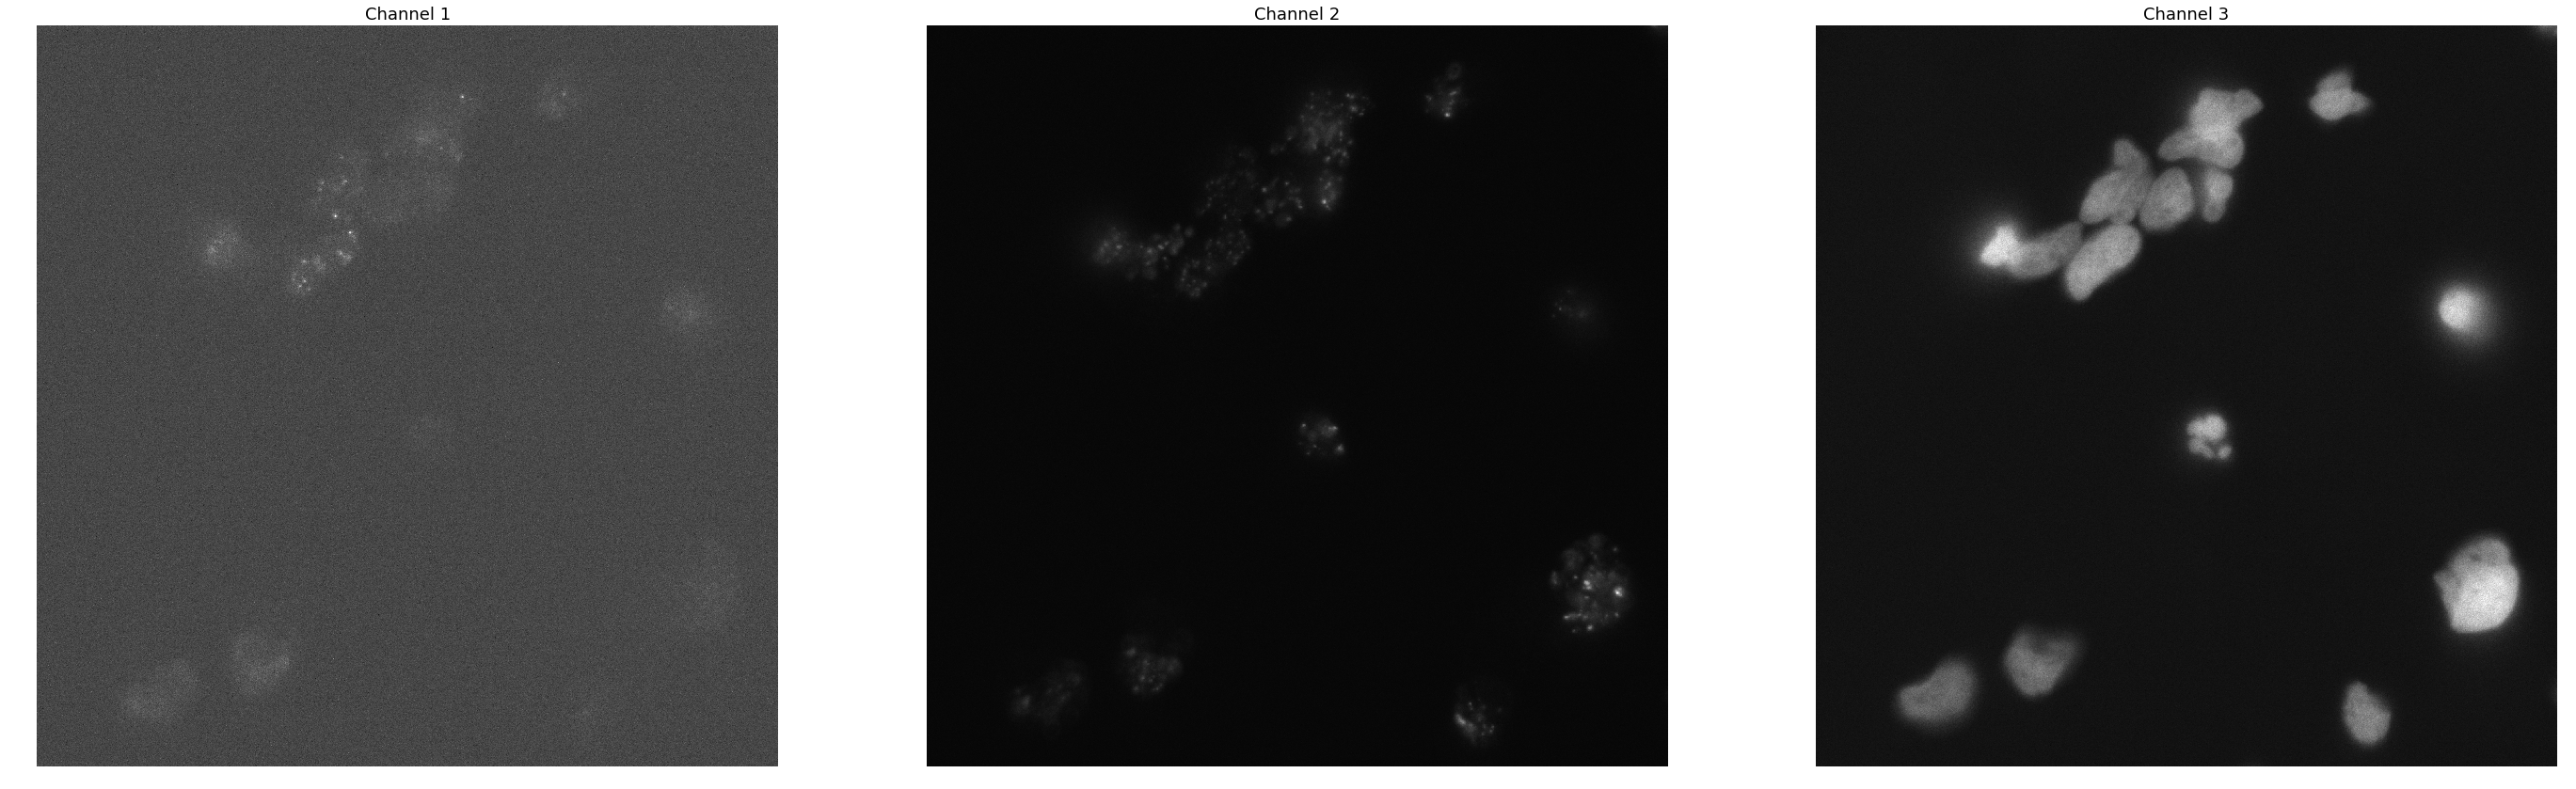

In [3]:
# Find focused image.
from numpy import zeros, std, where, mean, max
from matplotlib.pyplot import subplots, cm
varianceArr = zeros(noSlices)
for i in range(noSlices):
    varianceArr[i] = std(zLambda2Stack[i, :, :].flatten())
idxFocused = where(varianceArr == max(varianceArr))[0][0]
lambda1Img = mean(zLambda1Stack[(idxFocused - 1) : (idxFocused + 1), :, :], axis = 0)
lambda2Img = mean(zLambda2Stack[(idxFocused - 1) : (idxFocused + 1), :, :], axis = 0)
lambda3Img = mean(zLambda3Stack[(idxFocused - 1) : (idxFocused + 1), :, :], axis = 0)
# Display averaged images that will be analyzed.
figObj, (ax1Ojb, ax2Obj, ax3Obj) = subplots(nrows = 1, ncols = 3, squeeze = True)
figObj.set_figheight(16)
figObj.set_figwidth(48)
ax1Ojb.imshow(lambda1Img / max(lambda1Img.flatten()), cmap = cm.gray)
ax1Ojb.axis('off')
ax1Ojb.set_title('Channel 1', fontsize = 18)
ax2Obj.imshow(lambda2Img / max(lambda2Img.flatten()), cmap = cm.gray)
ax2Obj.axis('off')
ax2Obj.set_title('Channel 2', fontsize = 18)
ax3Obj.imshow(lambda3Img / max(lambda3Img.flatten()), cmap = cm.gray)
ax3Obj.axis('off')
ax3Obj.set_title('Channel 3', fontsize = 18)

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


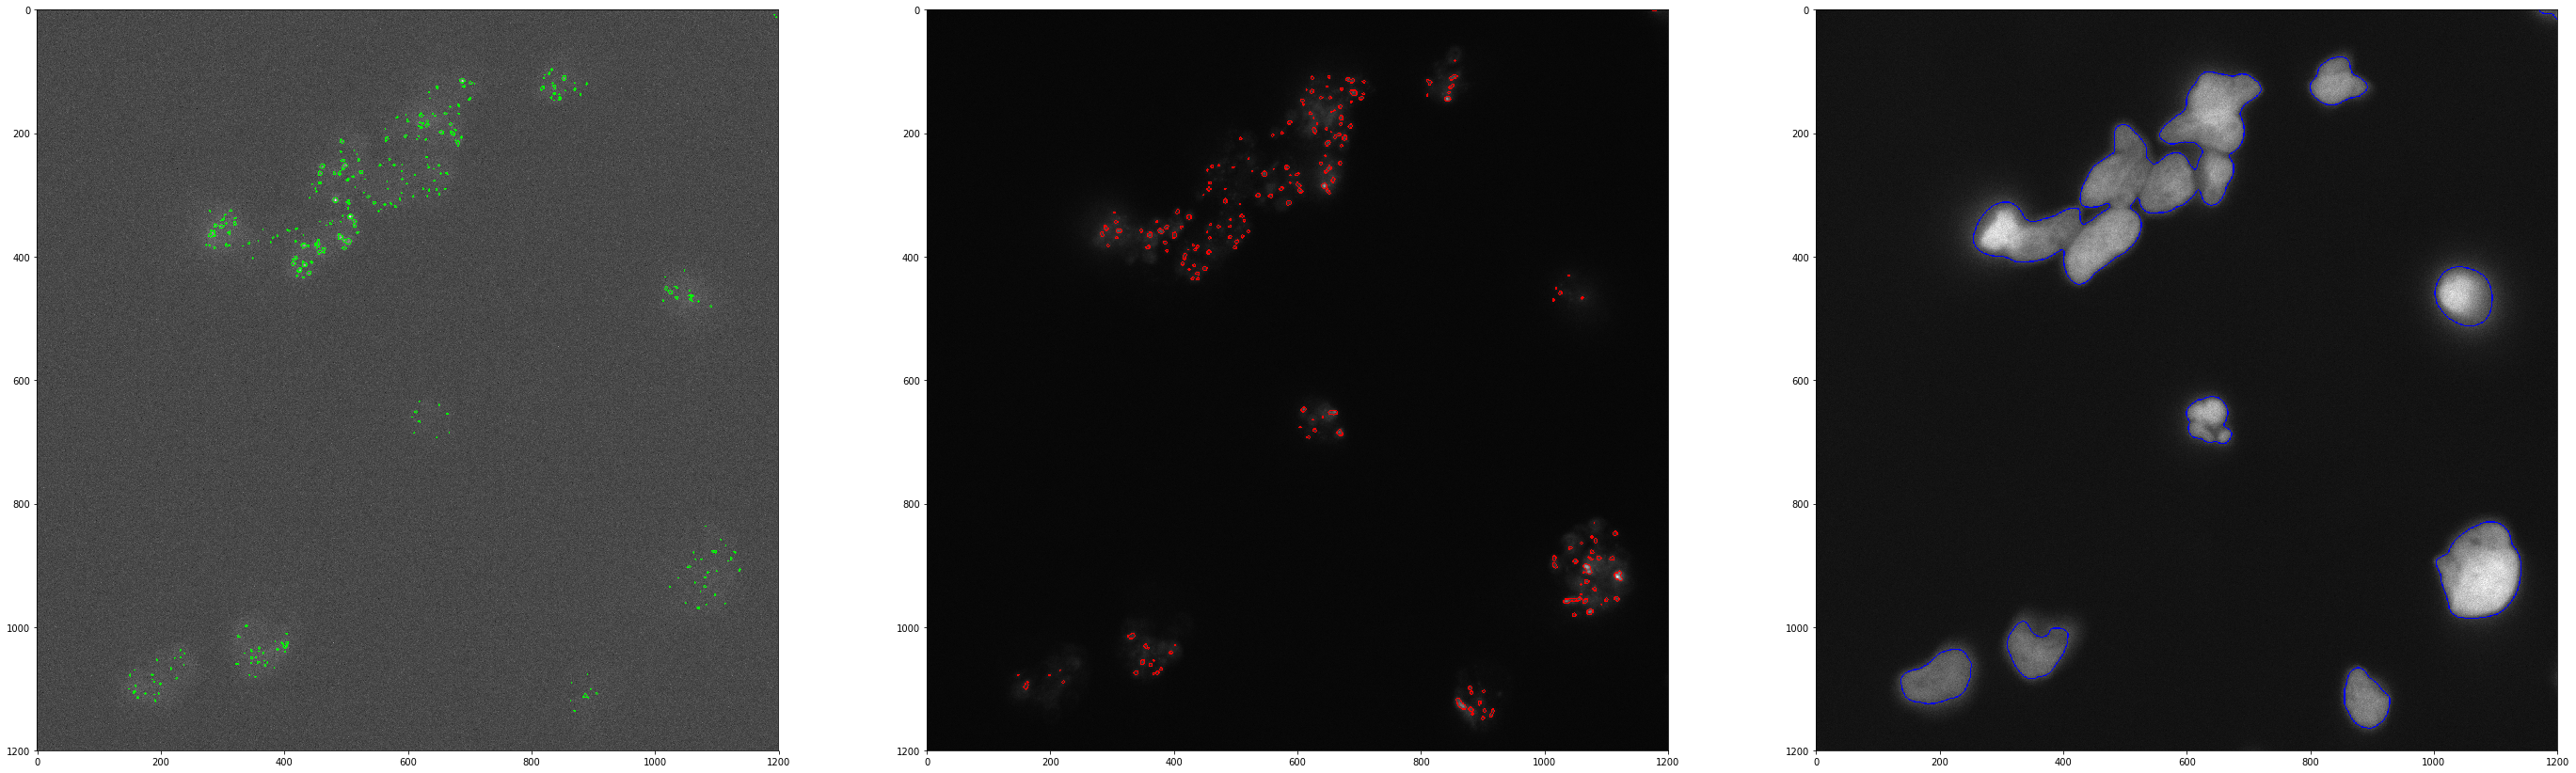

In [4]:
# Segment puncta.
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian, threshold_otsu
from numpy import min, sqrt, stack
from skimage.segmentation import morphological_chan_vese, find_boundaries

#Define dog filter.
def dogfilter(rawImg, objDia):
    sigma1 = objDia / (sqrt(2) + 1)
    sigma2 = objDia * sqrt(2)
    gauss1Img = gaussian(rawImg, sigma1)
    gauss2Img = gaussian(rawImg, sigma2)
    dogImg = gauss1Img - gauss2Img
    dogImg -= min(dogImg.flatten())
    return dogImg

# Equalize histogram.
eqLambda1Img = equalize_adapthist(lambda1Img, clip_limit = 0.003)
eqLambda2Img = equalize_adapthist(lambda2Img, clip_limit = 0.003)
eqLambda3Img = equalize_adapthist(lambda3Img, clip_limit = 0.003)

# Apply dog filter.
dogLambda1Img = dogfilter(eqLambda1Img, 3)
dogLambda2Img = dogfilter(eqLambda2Img, 3)

# Segment.
bckgrd1 = mean(dogLambda1Img) + 3 * std(dogLambda1Img.flatten())
bckgrd2 = mean(dogLambda2Img + 3 * std(dogLambda2Img.flatten()))
bwLambda1Img = dogLambda1Img > max((threshold_otsu(dogLambda1Img), bckgrd1))
bwLambda2Img = dogLambda2Img > max((threshold_otsu(dogLambda2Img), bckgrd2))
gaussLambda3Img = gaussian(eqLambda3Img, 3)
bwLambda3Img = gaussLambda3Img > threshold_otsu(gaussLambda3Img)

# Boundaries.
boundLambda1Img = find_boundaries(bwLambda1Img * bwLambda3Img)
boundLambda2Img = find_boundaries(bwLambda2Img * bwLambda3Img)
boundLambda3Img = find_boundaries(bwLambda3Img)

# Display.
overLambda1Img = stack((eqLambda1Img, eqLambda1Img, eqLambda1Img), axis = -1)
overLambda1Img[boundLambda1Img, 0] = 0.0
overLambda1Img[boundLambda1Img, 1] = 1.0
overLambda1Img[boundLambda1Img, 2] = 0.0
overLambda2Img = stack((eqLambda2Img, eqLambda2Img, eqLambda2Img), axis = -1)
overLambda2Img[boundLambda2Img, 0] = 1.0
overLambda2Img[boundLambda2Img, 1] = 0.0
overLambda2Img[boundLambda2Img, 2] = 0.0
overLambda3Img = stack((eqLambda3Img, eqLambda3Img, eqLambda3Img), axis = -1)
overLambda3Img[boundLambda3Img, 0] = 0.0
overLambda3Img[boundLambda3Img, 1] = 0.0
overLambda3Img[boundLambda3Img, 2] = 1.0

figObj, (ax1Obj, ax2Obj, ax3Obj) = subplots(nrows = 1, ncols = 3, squeeze = True)
figObj.set_figheight(16)
figObj.set_figwidth(48)
ax1Obj.imshow(overLambda1Img)
ax2Obj.imshow(overLambda2Img)
ax3Obj.imshow(overLambda3Img)